# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [3]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [4]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

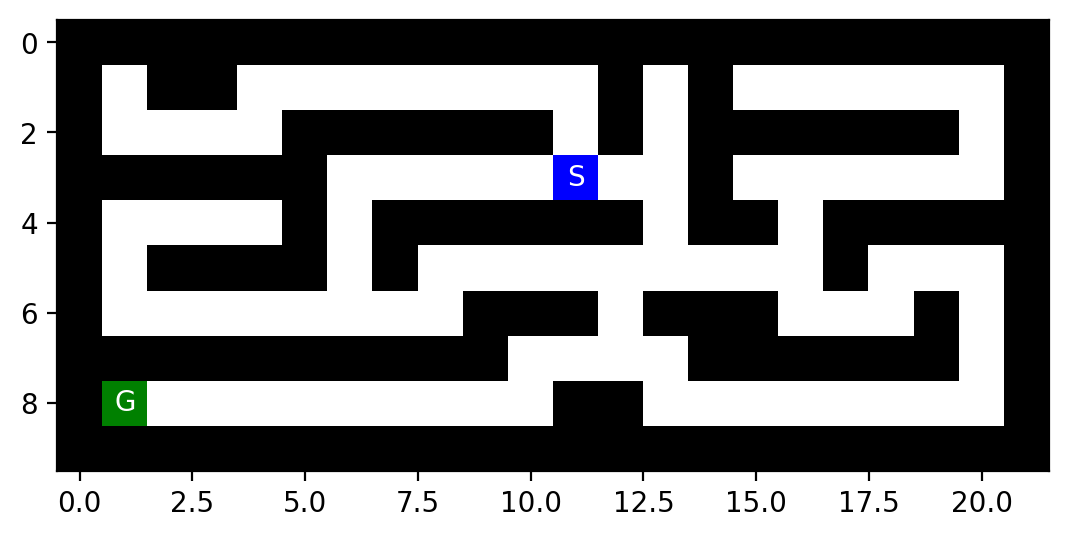

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [6]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [7]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [8]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [9]:
# Define the search problem for the Maze

# Example: Maze represented as a 2D grid
# 0 = free space, 1 = wall
maze = [
    [0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0]
]

# Initial and goal states
initial_state = (0, 0)   # starting position (row, col)
goal_state = (4, 4)      # target position (row, col)

# Actions that can be taken from any state
actions = ["UP", "DOWN", "LEFT", "RIGHT"]

# Transition model: returns the new state after performing an action
def transition_model(state, action):
    row, col = state
    if action == "UP":
        new_state = (row - 1, col)
    elif action == "DOWN":
        new_state = (row + 1, col)
    elif action == "LEFT":
        new_state = (row, col - 1)
    elif action == "RIGHT":
        new_state = (row, col + 1)
    else:
        new_state = state

    # Check for boundaries and walls
    if (0 <= new_state[0] < len(maze) and
        0 <= new_state[1] < len(maze[0]) and
        maze[new_state[0]][new_state[1]] == 0):
        return new_state
    else:
        return state  # invalid move stays in place

# Path cost: assume uniform cost (1 per move)
def path_cost(path):
    return len(path) - 1

search_problem = {
    "initial_state": initial_state,
    "actions": actions,
    "transition_model": transition_model,
    "goal_state": goal_state,
    "path_cost": path_cost
}

print("Search problem defined successfully.")


Search problem defined successfully.


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [10]:
# Estimate problem size for the Maze

# n: number of possible states (non-wall cells)
n = sum(cell == 0 for row in maze for cell in row)

# d: depth of optimal solution (e.g., shortest path length)
# (Here we can only estimate; assume around Manhattan distance)
start_r, start_c = initial_state
goal_r, goal_c = goal_state
d = abs(goal_r - start_r) + abs(goal_c - start_c)

# m: maximum depth of tree (worst case, visiting all states)
m = n

# b: maximum branching factor (each cell can have up to 4 neighbors)
b = 4

estimates = {
    "n (state space size)": n,
    "d (optimal depth)": d,
    "m (max depth)": m,
    "b (branching factor)": b
}

print("Problem size estimates:")
for k, v in estimates.items():
    print(f"{k}: {v}")


Problem size estimates:
n (state space size): 18
d (optimal depth): 8
m (max depth): 18
b (branching factor): 4


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

Path form start to goal using BFS:


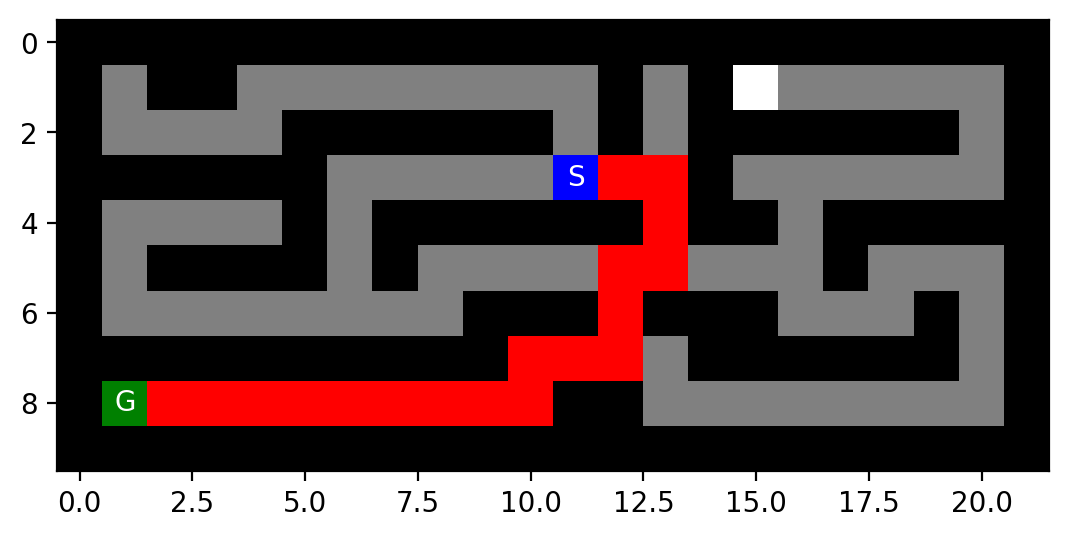

Path form start to goal using DFS:


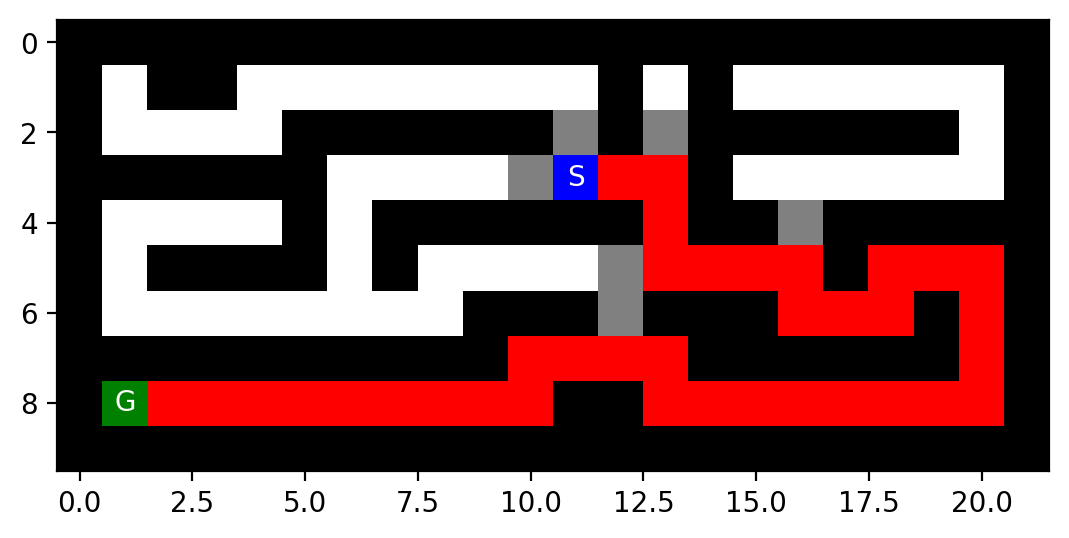

In [11]:
# Your code goes here
import maze_helper as mh
import matplotlib.pyplot as plt
import  numpy as np
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
    def __str__(self):
        return f"pos = ({self.pos[0]} ,{self.pos[1]}); parent = {self.parent}"
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
        while not node.parent is None:
            node = node.parent
            path.append(node)
        path.reverse()
        return(path)
def BFS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze




# solution = BFS(maze)
# print(f"Path form start to goal using BFS:")
# print_solution(solution)
# print(f"Cost from start to goal: {len(solution)}")


def DFS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
print(f"Path form start to goal using BFS:")
solution = BFS(maze)
mh.show_maze(solution)
print(f"Path form start to goal using DFS:")
solution = DFS(maze)
mh.show_maze(solution)


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

- **BFS with reached set**  
  BFS luôn cần `reached` (hay `visited`) để tránh thăm lại cùng một state.  
  Nếu bỏ `reached`, BFS có thể lặp vô hạn trong graph có chu trình.

- **DFS without reached**  
  DFS thường triển khai mà không lưu toàn bộ `reached` để tiết kiệm bộ nhớ.  
  Tuy nhiên, nếu không kiểm soát thì DFS cũng dễ rơi vào vòng lặp vô hạn.  
  Do đó, DFS **ít nhất phải có cycle checking** trong nhánh hiện tại (path-based checking):  
  - Khi mở rộng node mới, không cho phép quay lại một state đã xuất hiện trong path hiện tại.  
  - Điều này ngăn DFS đi vòng tròn vô hạn trong một nhánh, nhưng không ngăn việc khám phá lại cùng state theo nhánh khác.

**Kết luận:**  
- BFS cần `reached` để đảm bảo đầy đủ và tránh lặp.  
- DFS không có `reached` toàn cục → phải có **cycle checking trong path hiện tại**, nếu không sẽ bị kẹt trong vòng lặp.


In [12]:
# Simple graph with a cycle: A -> B -> C -> A
graph = {
    "A": ["B"],
    "B": ["C"],
    "C": ["A"]
}

def dfs_without_cycle_check(start, goal):
    stack = [(start, [start])]
    while stack:
        state, path = stack.pop()
        if state == goal:
            return path
        for nxt in graph[state]:
            # không cycle check
            stack.append((nxt, path + [nxt]))
    return None

def dfs_with_cycle_check(start, goal):
    stack = [(start, [start])]
    while stack:
        state, path = stack.pop()
        if state == goal:
            return path
        for nxt in graph[state]:
            if nxt not in path:  # cycle checking
                stack.append((nxt, path + [nxt]))
    return None

print("DFS without cycle check (goal=C):", dfs_without_cycle_check("A", "C"))
print("DFS with cycle check (goal=C):   ", dfs_with_cycle_check("A", "C"))


DFS without cycle check (goal=C): ['A', 'B', 'C']
DFS with cycle check (goal=C):    ['A', 'B', 'C']


Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

## Tính đầy đủ và tối ưu của các giải thuật

- **BFS (Breadth-First Search)**  
  - *Đầy đủ (Completeness)*: Có, BFS luôn tìm được lời giải nếu tồn tại (với hệ số phân nhánh hữu hạn).  
  - *Tối ưu (Optimality)*: Có, BFS tìm lời giải ngắn nhất nếu chi phí mỗi bước bằng nhau.  
  - *Độ phức tạp*:  
    - Thời gian: `O(b^d)` với `b` là hệ số phân nhánh, `d` là độ sâu của nghiệm gần nhất.  
    - Không gian: `O(b^d)` (do phải lưu toàn bộ frontier và reached).  

- **DFS (Depth-First Search, không dùng reached toàn cục)**  
  - *Đầy đủ*: Không, DFS có thể rơi vào vòng lặp vô hạn hoặc bỏ lỡ nghiệm nông nếu không có giới hạn độ sâu.  
  - *Tối ưu*: Không, vì DFS có thể trả về nghiệm dài hơn trong khi vẫn còn nghiệm ngắn hơn.  
  - *Độ phức tạp*:  
    - Thời gian: `O(b^m)` với `m` là độ sâu tối đa (có thể vô hạn).  
    - Không gian: `O(bm)` (chỉ cần lưu một nhánh từ gốc đến lá).  

- **GBFS (Greedy Best-First Search)**  
  - *Đầy đủ*: Không đảm bảo, vì có thể bị kẹt nếu heuristic dẫn vào ngõ cụt.  
  - *Tối ưu*: Không, GBFS không đảm bảo tìm được đường đi ngắn nhất.  
  - *Độ phức tạp*:  
    - Thời gian: phụ thuộc mạnh vào heuristic, trường hợp xấu là `O(b^d)`.  
    - Không gian: cùng bậc với BFS, do lưu trong hàng đợi ưu tiên.  

- **A\***  
  - *Đầy đủ*: Có, nếu heuristic chấp nhận được (admissible) và hệ số phân nhánh hữu hạn.  
  - *Tối ưu*: Có, nếu heuristic vừa admissible vừa consistent.  
  - *Độ phức tạp*:  
    - Thời gian: vẫn mang tính chất lũy thừa, nhưng thường ít hơn BFS khi heuristic tốt.  
    - Không gian: cũng lũy thừa, do phải lưu tất cả node đã sinh.  

---

## So sánh BFS và DFS về không gian

- **BFS**: cần bộ nhớ cho tất cả node ở độ sâu `d`, tăng theo hàm mũ `O(b^d)`.  
- **DFS**: chỉ cần bộ nhớ cho một đường đi và các nhánh chưa mở rộng, tỷ lệ thuận với độ sâu `O(bm)`.  
- **Kết luận**: BFS tối ưu nhưng tốn bộ nhớ, DFS tiết kiệm bộ nhớ nhưng không tối ưu và không đầy đủ trong đồ thị vô hạn.


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

Path form start to goal using Greedy Best-First Search:


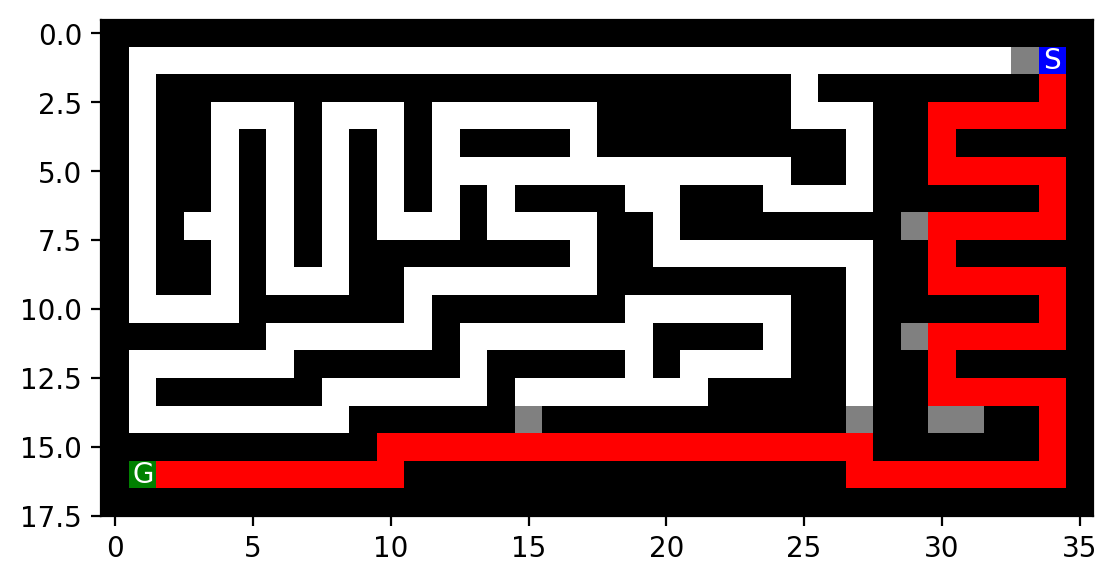

Path form start to goal using A* Search:


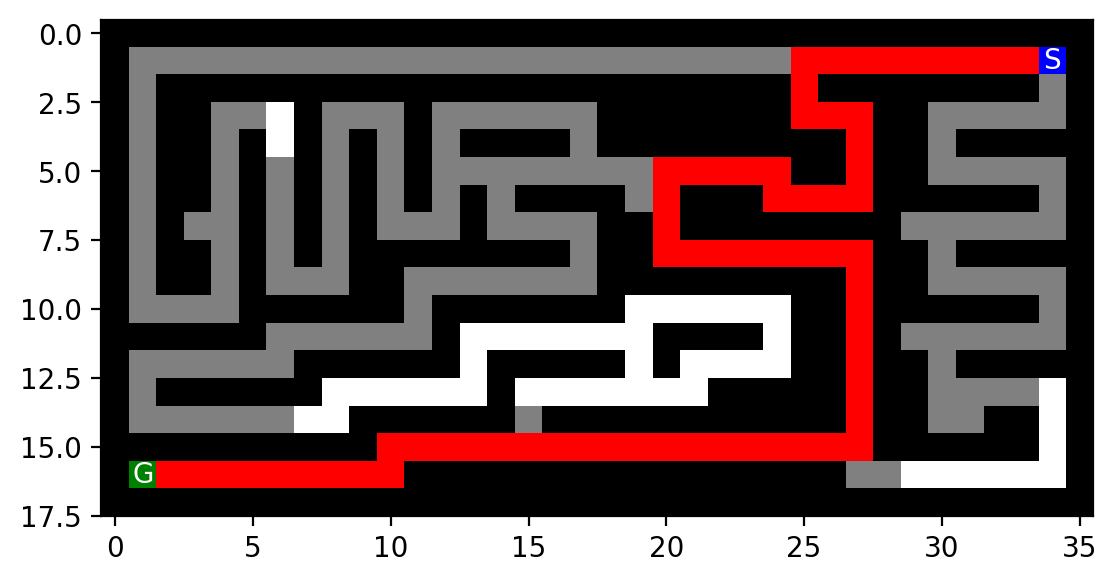

In [13]:
# Your code goes here
def Greedy_best_first_search(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Sort the frontier based on the heuristic (Manhattan distance)
        frontier.sort(key=lambda node: abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)  # Pop the node with the lowest heuristic value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

def A_star_search(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Sort the frontier based on the f(n) = g(n) + h(n)
        frontier.sort(key=lambda node: node.cost + abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)  # Pop the node with the lowest f(n) value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

with open("medium_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
print(f"Path form start to goal using Greedy Best-First Search:")
solution = Greedy_best_first_search(maze)
mh.show_maze(solution)
print(f"Path form start to goal using A* Search:")
solution = A_star_search(maze)
mh.show_maze(solution)

Are your implementations complete and optimal? What is the time and space complexity?

## Đánh giá về độ đầy đủ, tối ưu và độ phức tạp

- **BFS (Breadth-First Search)**  
  - *Đầy đủ*: Có (sẽ tìm thấy nghiệm nếu tồn tại).  
  - *Tối ưu*: Có, nếu mọi bước đi có chi phí bằng nhau.  
  - *Độ phức tạp*:  
    - Thời gian: `O(b^d)` với `b` = hệ số phân nhánh, `d` = độ sâu nghiệm nông nhất.  
    - Không gian: `O(b^d)` (rất tốn bộ nhớ).  

- **DFS (Depth-First Search, không có reached toàn cục, chỉ cycle check)**  
  - *Đầy đủ*: Không (có thể lặp vô hạn hoặc bỏ lỡ nghiệm).  
  - *Tối ưu*: Không (có thể trả về đường đi dài hơn).  
  - *Độ phức tạp*:  
    - Thời gian: `O(b^m)` với `m` = độ sâu tối đa.  
    - Không gian: `O(bm)` (ít tốn bộ nhớ, tỷ lệ thuận với độ sâu).  

- **GBFS (Greedy Best-First Search)**  
  - *Đầy đủ*: Không đảm bảo (có thể bị kẹt ở heuristic kém).  
  - *Tối ưu*: Không.  
  - *Độ phức tạp*:  
    - Thời gian: phụ thuộc vào heuristic, xấu nhất `O(b^d)`.  
    - Không gian: `O(b^d)` (ưu tiên queue cũng lớn như BFS).  

- **A\***  
  - *Đầy đủ*: Có (nếu heuristic admissible và nhất quán).  
  - *Tối ưu*: Có, với heuristic admissible.  
  - *Độ phức tạp*:  
    - Thời gian: có thể lũy thừa nhưng thường ít hơn BFS nhờ heuristic.  
    - Không gian: vẫn lũy thừa, phải lưu tất cả node đã sinh.  

---

### So sánh BFS và DFS về không gian
- BFS cần lưu toàn bộ frontier ở độ sâu `d` ⇒ `O(b^d)` (rất lớn).  
- DFS chỉ cần lưu một nhánh + node anh em ⇒ `O(bm)` (rất nhỏ so với BFS).  
- Đây là điểm khác biệt quan trọng: BFS tối ưu nhưng tốn bộ nhớ, DFS tiết kiệm bộ nhớ nhưng không tối ưu và không đầy đủ.


## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [14]:
#BFS

def BFS_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        node_expanded += 1
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

#DFS

def DFS_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        node_expanded += 1
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

def Greedy_best_first_search_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        frontier.sort(key=lambda node: abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)
        node_expanded += 1
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

def A_star_search_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        frontier.sort(key=lambda node: node.cost + abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)
        node_expanded += 1
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth,  max_of_node_in_memory, max_frontier_size


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

Results for maze in file: small_maze.txt


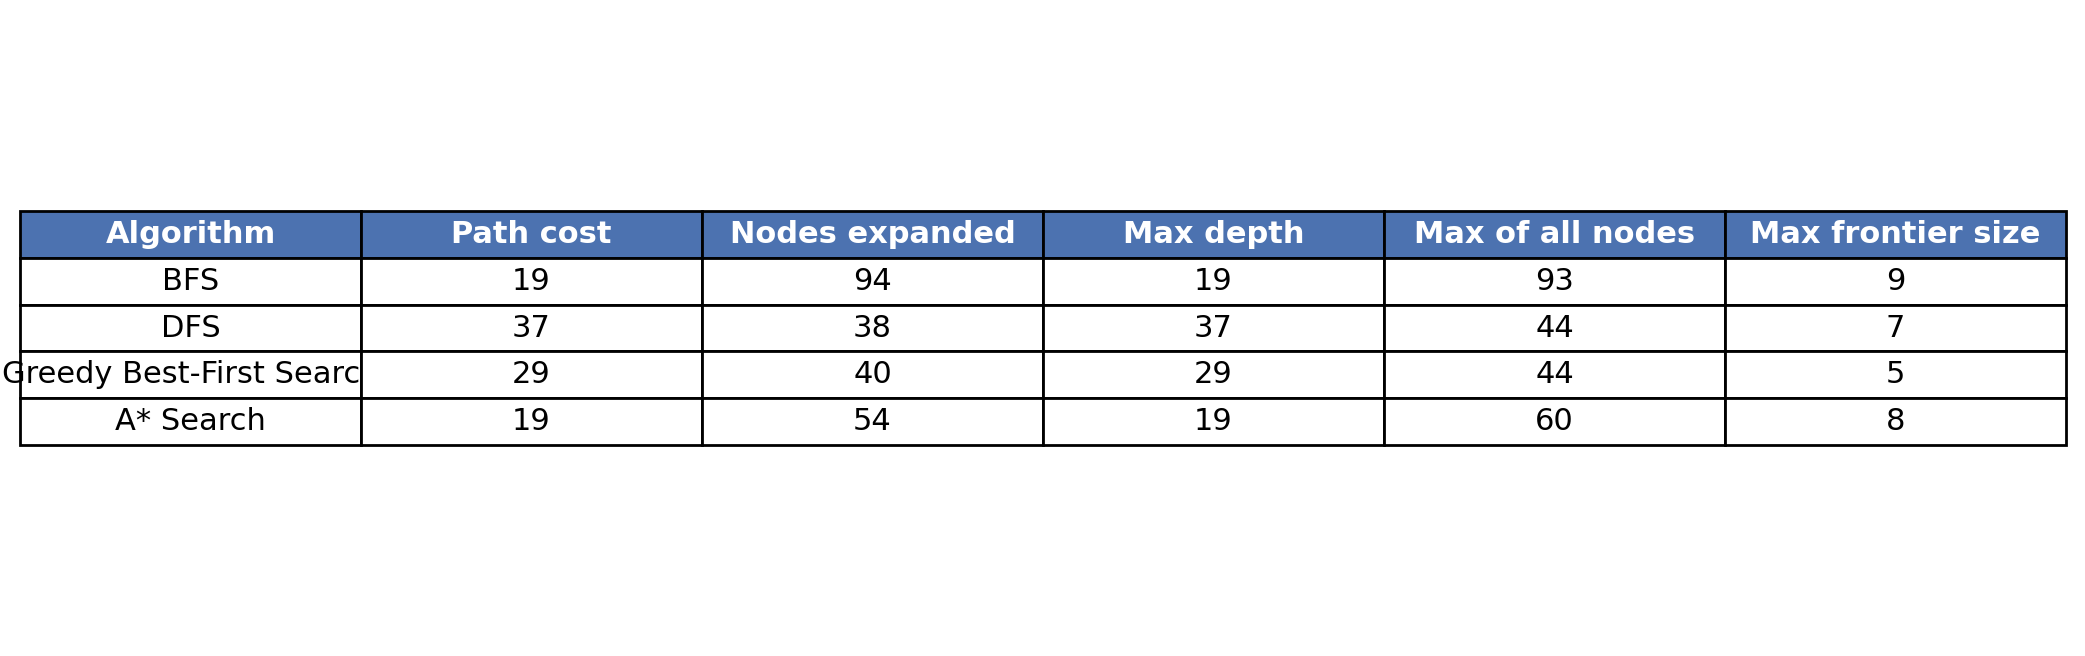

Results for maze in file: medium_maze.txt


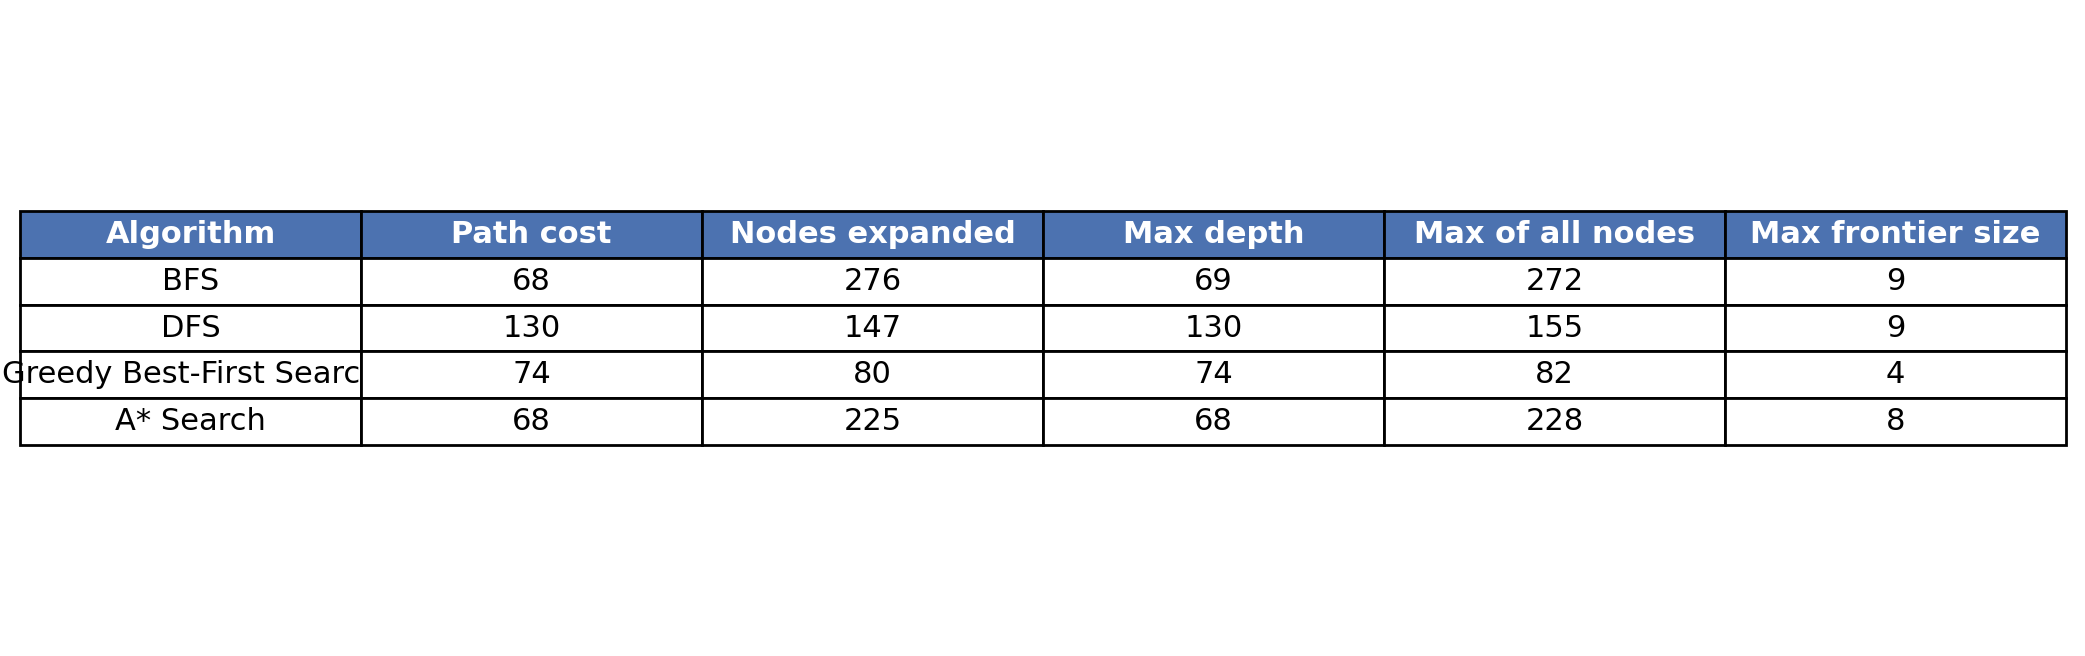

Results for maze in file: large_maze.txt


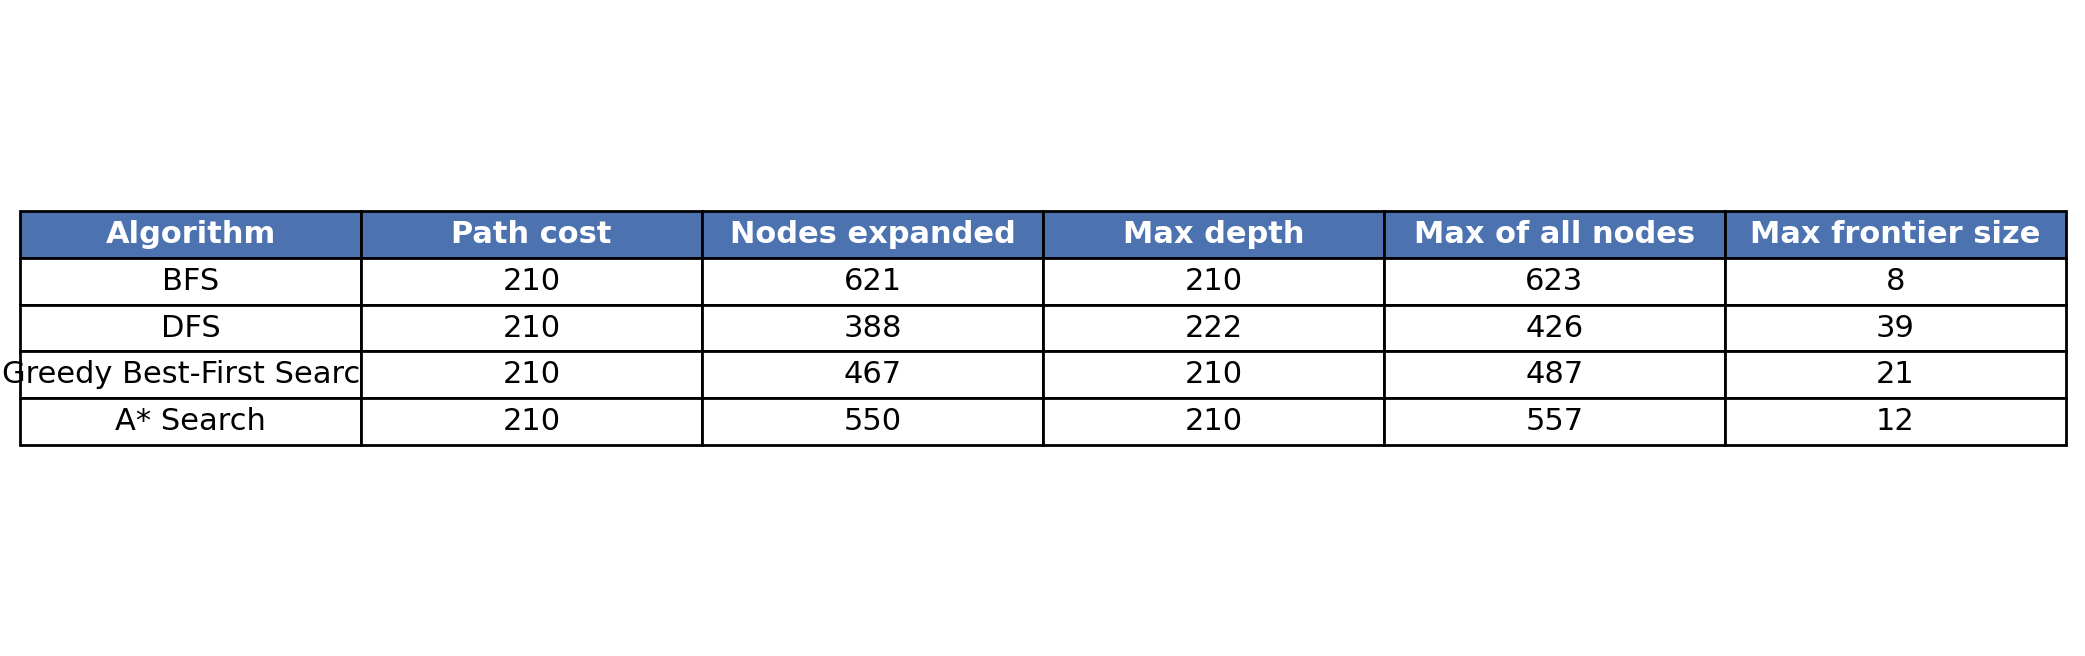

Results for maze in file: loops_maze.txt


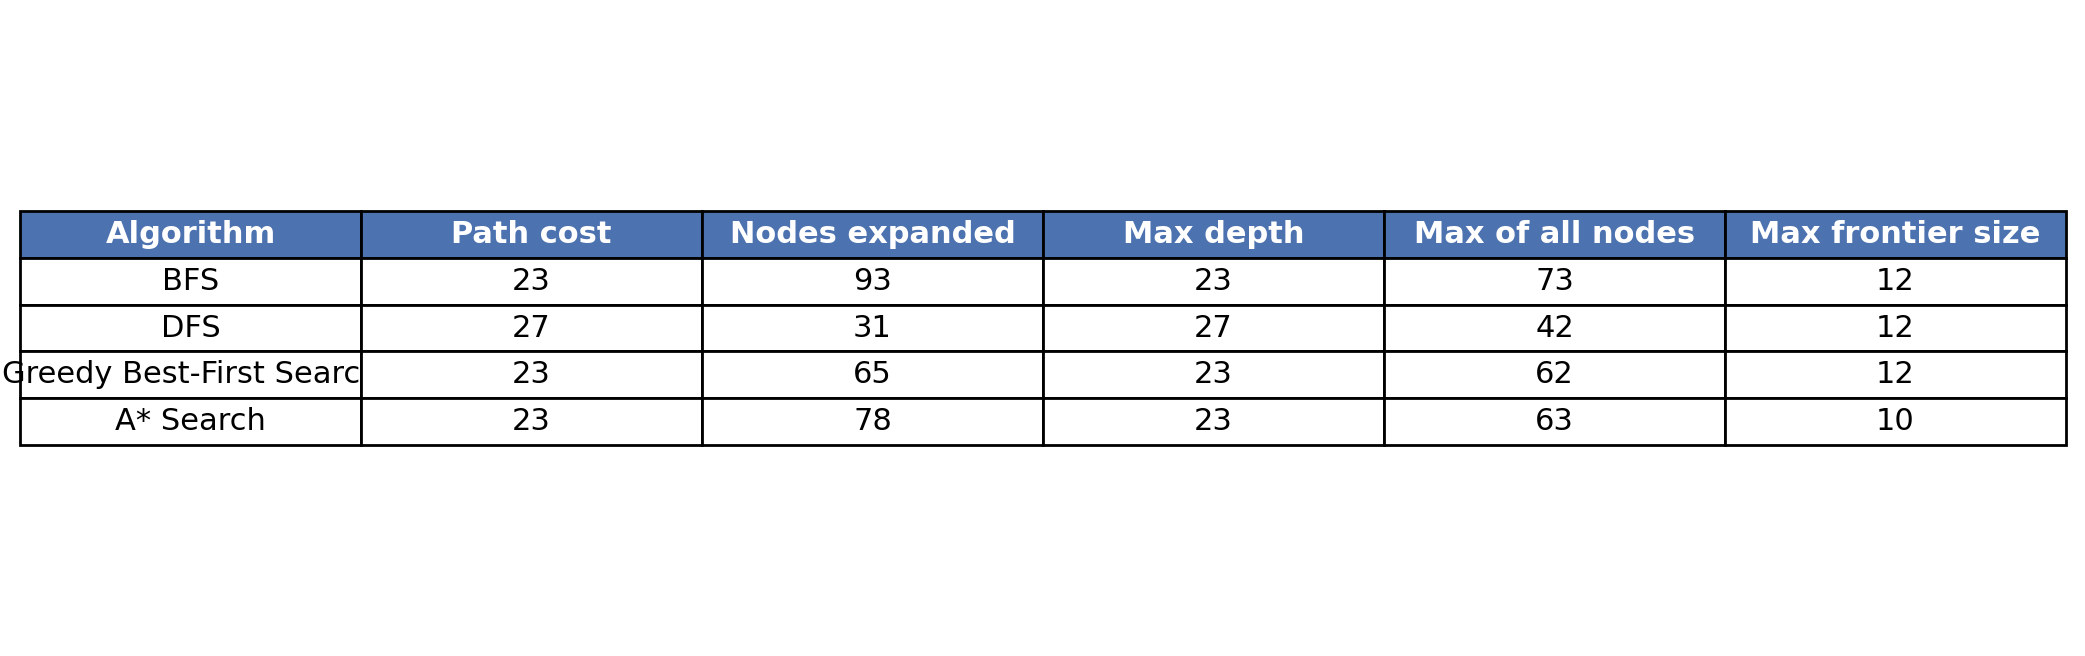

Results for maze in file: L_maze.txt


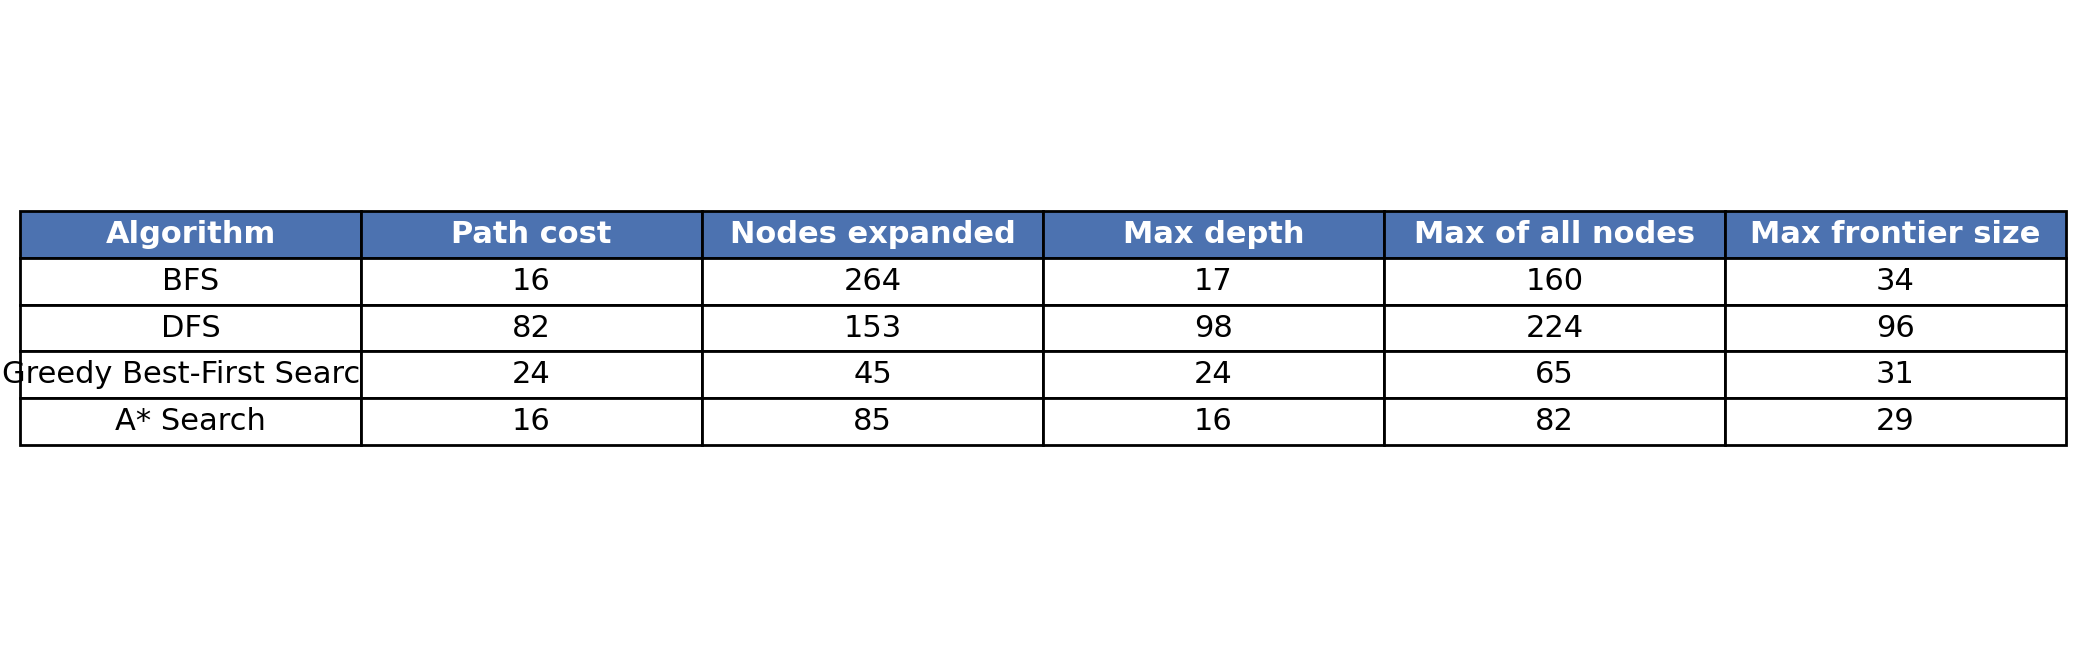

Results for maze in file: empty_maze.txt


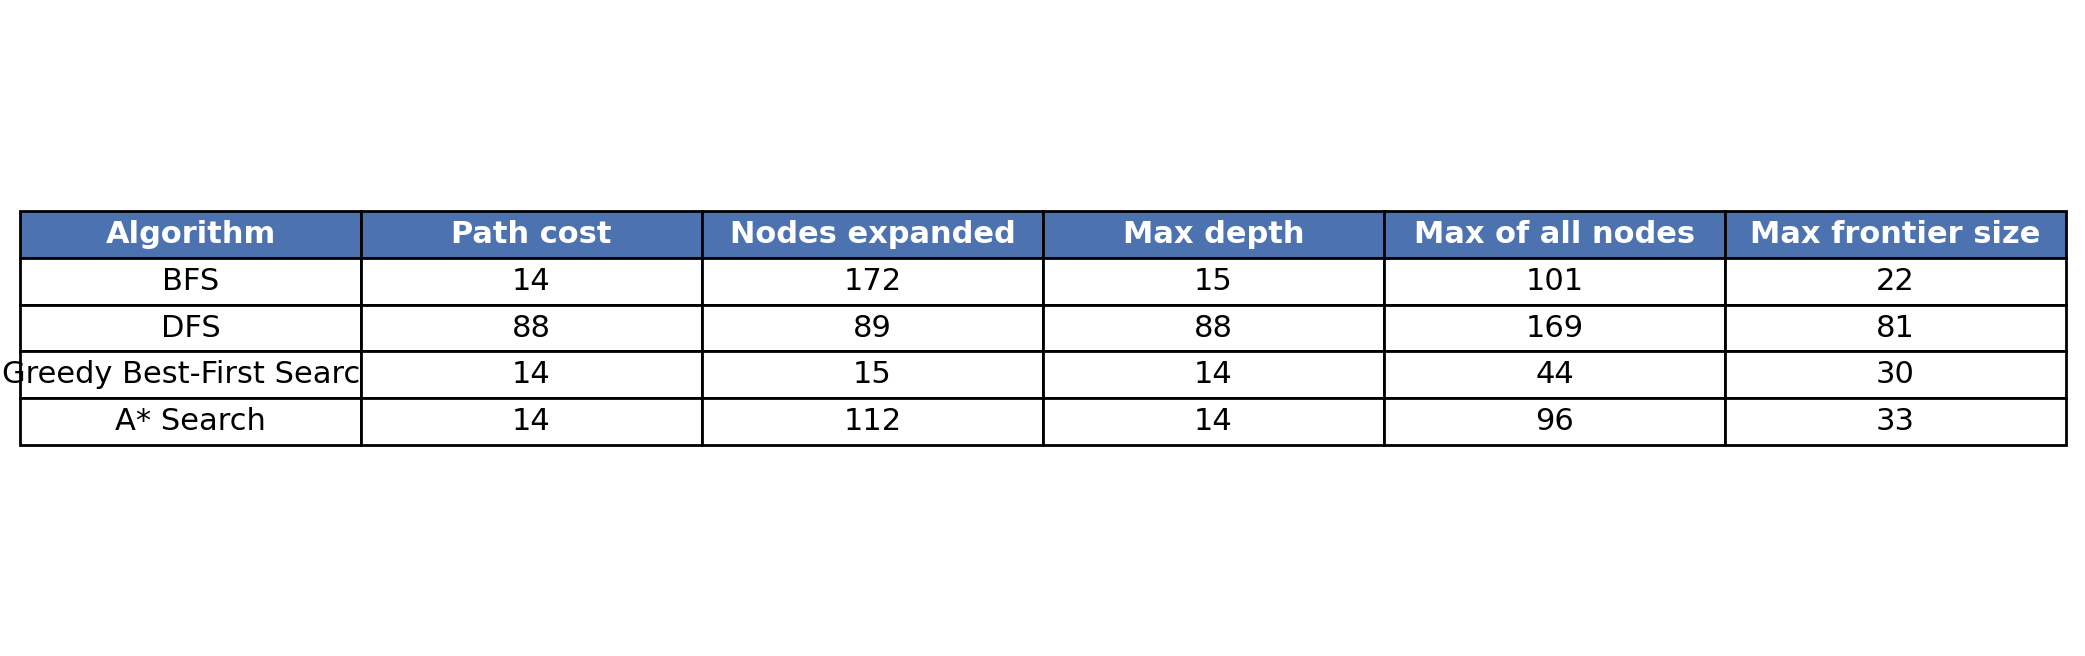

Results for maze in file: empty_maze_2.txt


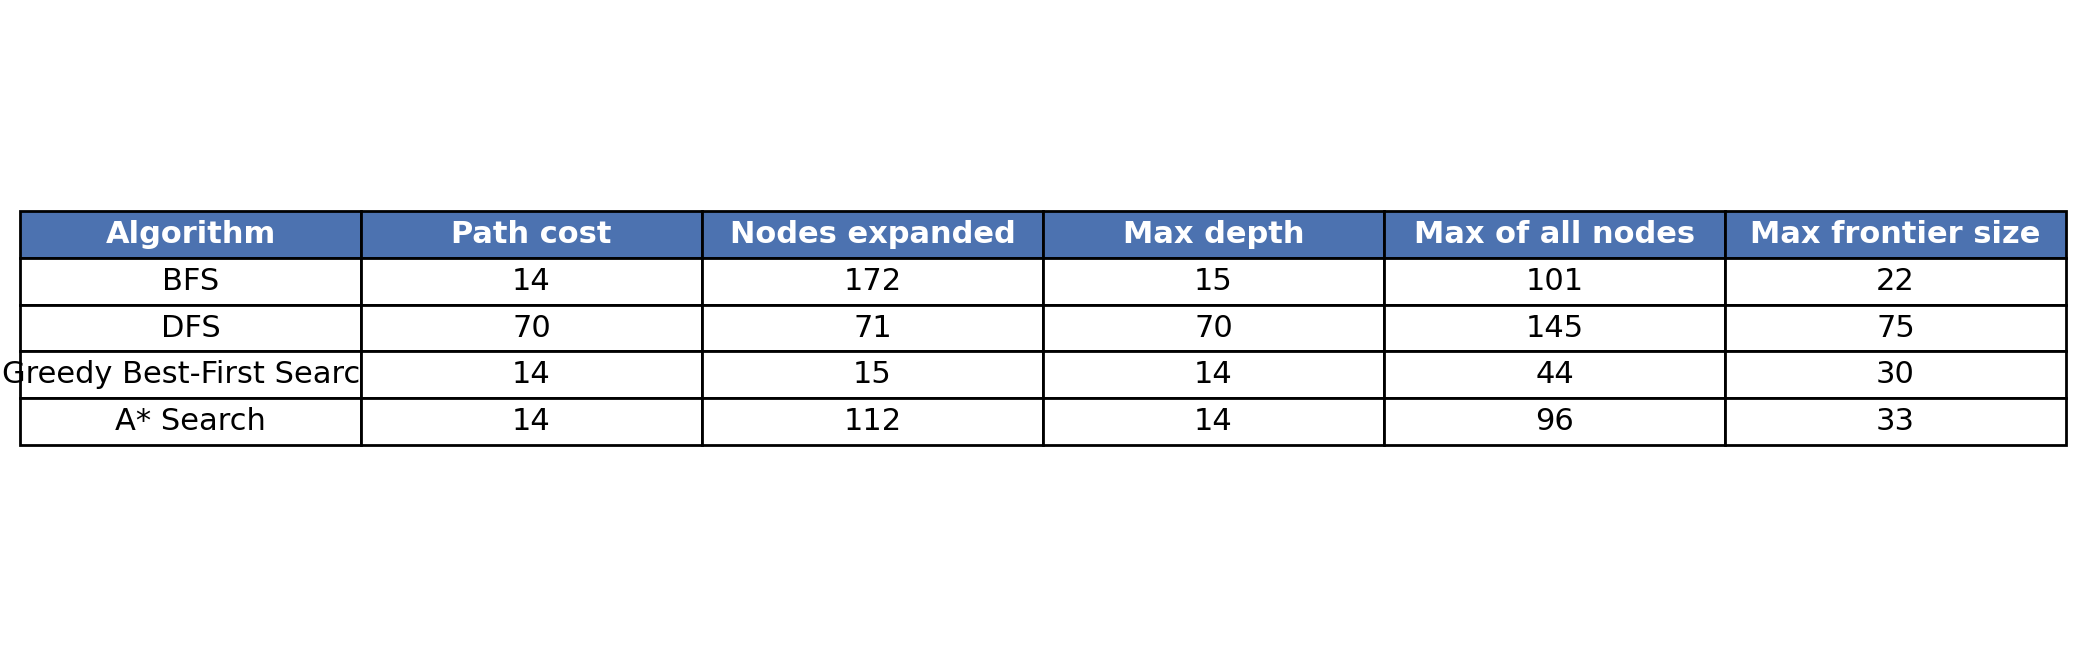

Results for maze in file: open_maze.txt


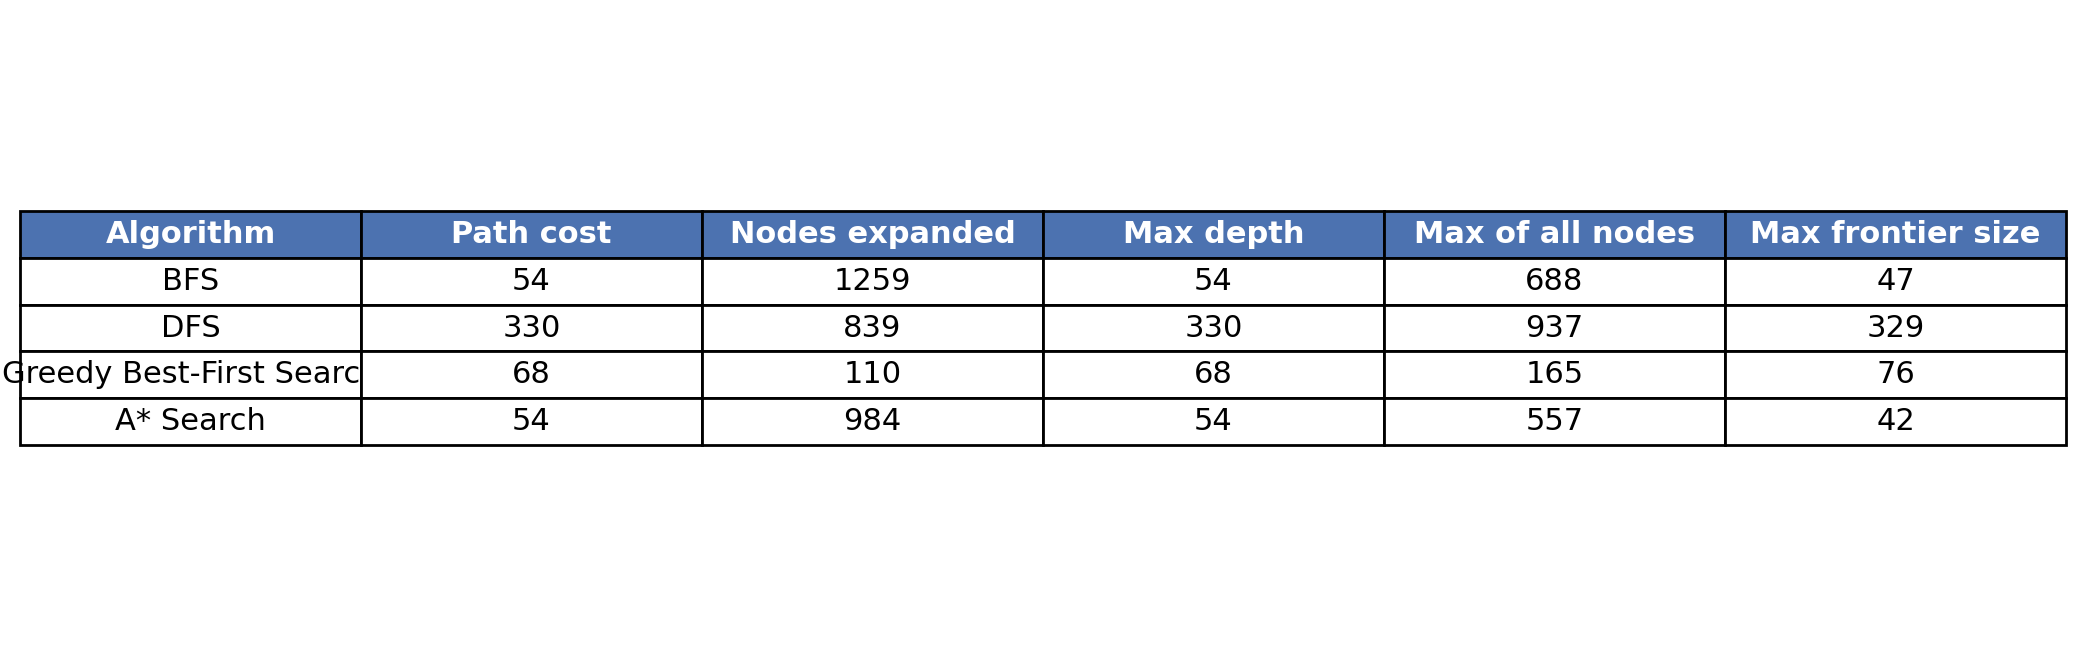

In [15]:
maze_str = ["small_maze.txt", "medium_maze.txt", "large_maze.txt","loops_maze.txt","L_maze.txt","empty_maze.txt","empty_maze_2.txt","open_maze.txt"]

maze_results_each_file = {}
for file in maze_str:
    with open(file, "r") as f:
        maze_str = f.read()
    maze = mh.parse_maze(maze_str)
    #BFS
    BFS_result = BFS_custom(maze)
    #DFS
    DFS_result = DFS_custom(maze)
    #Greedy
    Greedy_result = Greedy_best_first_search_custom(maze)
    #A*
    A_star_result = A_star_search_custom(maze)
    maze_results_each_file[file] = {
        "BFS": BFS_result,
        "DFS": DFS_result,
        "Greedy Best-First Search": Greedy_result,
        "A* Search": A_star_result
    }
    columns = ('Algorithm', 'Path cost', 'Nodes expanded', 'Max depth', 'Max of all nodes', 'Max frontier size')
    rows = ['BFS', 'DFS', 'Greedy Best-First Search', 'A* Search']

    data = [
            ['BFS', BFS_result[1], BFS_result[2], BFS_result[3], BFS_result[4], BFS_result[5]],
            ['DFS', DFS_result[1], DFS_result[2], DFS_result[3], DFS_result[4], DFS_result[5]],
            ['Greedy Best-First Search', Greedy_result[1], Greedy_result[2], Greedy_result[3], Greedy_result[4], Greedy_result[5]],
            ['A* Search', A_star_result[1], A_star_result[2], A_star_result[3], A_star_result[4], A_star_result[5]]
    ]
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axis('off')
    table = ax.table(cellText=data,
                 colLabels=columns,
                 loc='center',
                 cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.4)
    for key, cell in table.get_celld().items():
        row, col = key
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4C72B0')
    print(f"Results for maze in file: {file}")
    plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

## Lessons Learned from Implementing Search Strategies

Qua việc cài đặt và so sánh BFS, DFS, GBFS và A*, có một số bài học quan trọng rút ra:

1. **Mỗi thuật toán có ưu và nhược điểm riêng**  
   - BFS đảm bảo tìm được lời giải ngắn nhất nhưng cực kỳ tốn bộ nhớ.  
   - DFS tiết kiệm bộ nhớ nhưng dễ bị lạc hướng, không đầy đủ và không tối ưu.  
   - GBFS nhanh trong nhiều trường hợp nhưng có thể đi sai hướng nếu heuristic kém.  
   - A* kết hợp được ưu điểm của BFS và GBFS: vừa đầy đủ vừa tối ưu (nếu heuristic tốt), nhưng vẫn tiêu tốn nhiều bộ nhớ.

2. **Trade-off giữa thời gian và không gian**  
   - BFS và A* có thời gian tìm kiếm hiệu quả hơn DFS trong không gian nhỏ, nhưng khi độ sâu tăng thì chi phí bộ nhớ trở thành vấn đề lớn.  
   - DFS cho thấy lợi thế về bộ nhớ, nhưng đổi lại là sự đánh đổi về độ tin cậy và chất lượng nghiệm.

3. **Tầm quan trọng của heuristic**  
   - Trong tìm kiếm có thông tin (GBFS, A*), chất lượng heuristic quyết định hiệu năng.  
   - Heuristic Manhattan (khoảng cách L1) cho bài toán mê cung hoạt động tốt, giúp A* cắt giảm rất nhiều số node mở rộng so với BFS.

4. **Tính thực tế trong triển khai**  
   - Cần cycle-checking trong DFS để tránh vòng lặp.  
   - Cần lưu ý về cấu trúc dữ liệu (queue, stack, priority queue) vì chúng ảnh hưởng trực tiếp đến hiệu quả.  
   - Visualization (vẽ maze, frontier, path) cực kỳ hữu ích để debug và hiểu rõ hành vi từng thuật toán.

---

### Kết luận
Việc triển khai nhiều chiến lược tìm kiếm giúp thấy rõ ràng rằng **không có thuật toán nào là tốt nhất trong mọi tình huống**. Sự lựa chọn phụ thuộc vào kích thước bài toán, giới hạn bộ nhớ, và liệu ta có thể xây dựng được một heuristic đủ tốt hay không.


## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

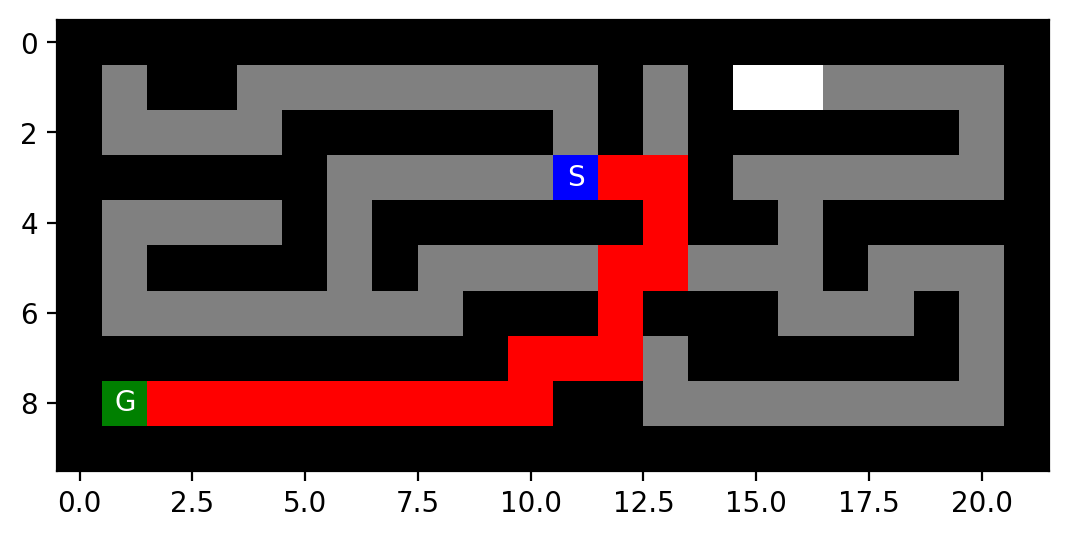

In [16]:
# Your code/answer goes here
import maze_helper as mh
import matplotlib.pyplot as plt
import  numpy as np

def DLS(node, depth, new_maze, end, action_effects):
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return True
        if depth <= 0:
            return False
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(new_maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                if DLS(new_node, depth - 1, new_maze, end, action_effects):
                    return True
        return False
def IDS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    max_depth = 1
    while True:
        start_node = Node(start, None, None, 0)
        if DLS(start_node, max_depth, new_maze, end, action_effects):
            return new_maze
        max_depth += 1
    return -1

with open("small_maze.txt", "r") as f:
    maze_str_small = f.read()
with open("medium_maze.txt", "r") as f:
    maze_str_medium = f.read()
small_maze = mh.parse_maze(maze_str_small)
medium_maze = mh.parse_maze(maze_str_medium)

solution = IDS(small_maze)
mh.show_maze(solution)

# solution = IDS(medium_maze)
# mh.show_maze(solution)


### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [17]:

#BFS_multi goals
def BFS_multi(maze, positions):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = positions
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        if node.pos in end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

#DFS multi goals
def DFS_multi(maze, positions):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    ends = positions
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        if node.pos in ends:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
#IDS multi goals
def new_IDS(maze, position):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  position
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    max_depth = 1
    while True:
        start_node = Node(start, None, None, 0)
        if DLS(start_node, max_depth, new_maze, end, action_effects):
            return new_maze
        max_depth += 1
    return new_maze
def DLS(node, depth, new_maze, end, action_effects):
        if node.pos in end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return True
        if depth <= 0:
            return False
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(new_maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                if DLS(new_node, depth - 1, new_maze, end, action_effects):
                    return True
        return False





Path form start to goal using DFS:


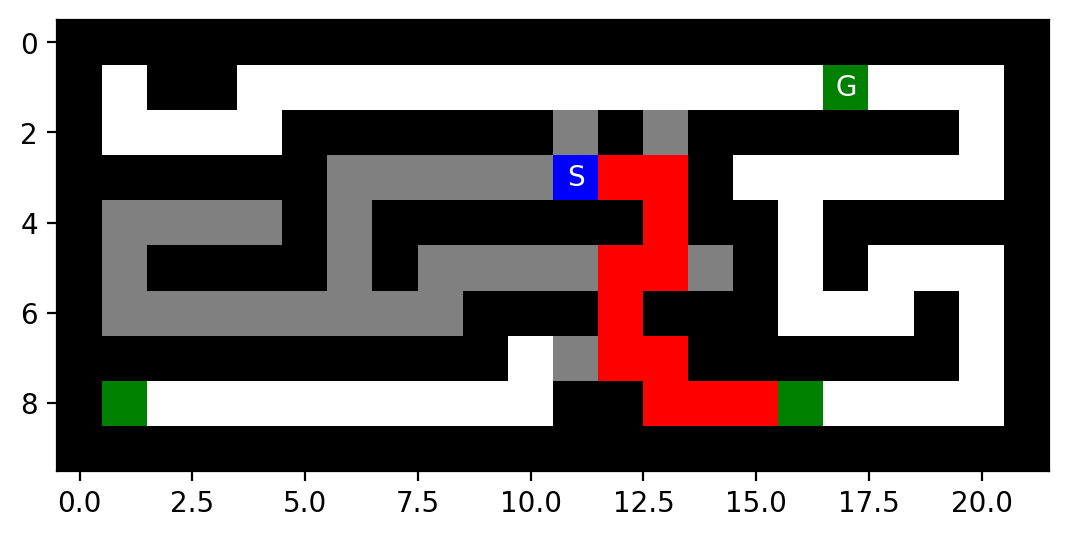

Path form start to goal using BFS:


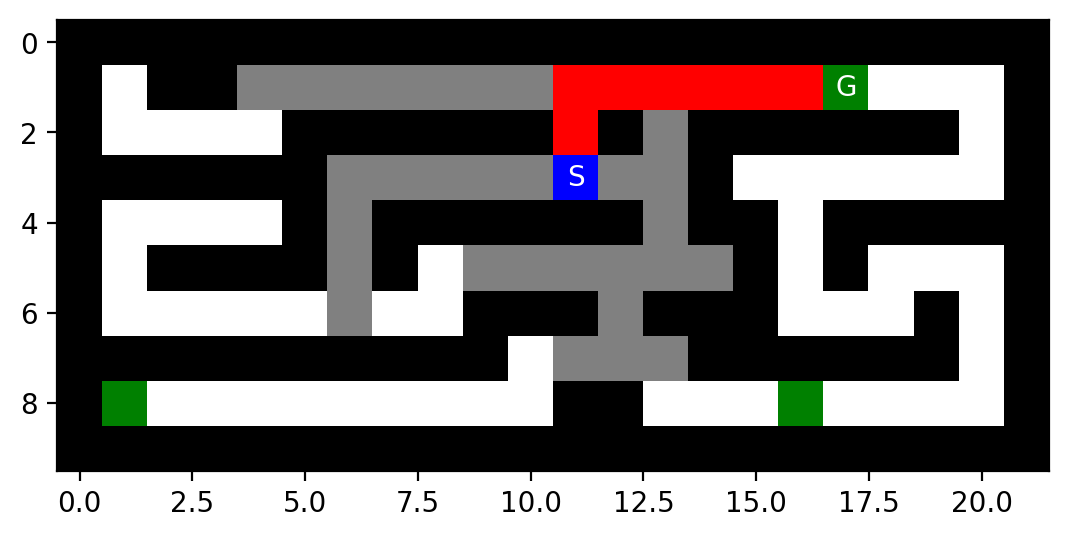

Path form start to goal using IDS:


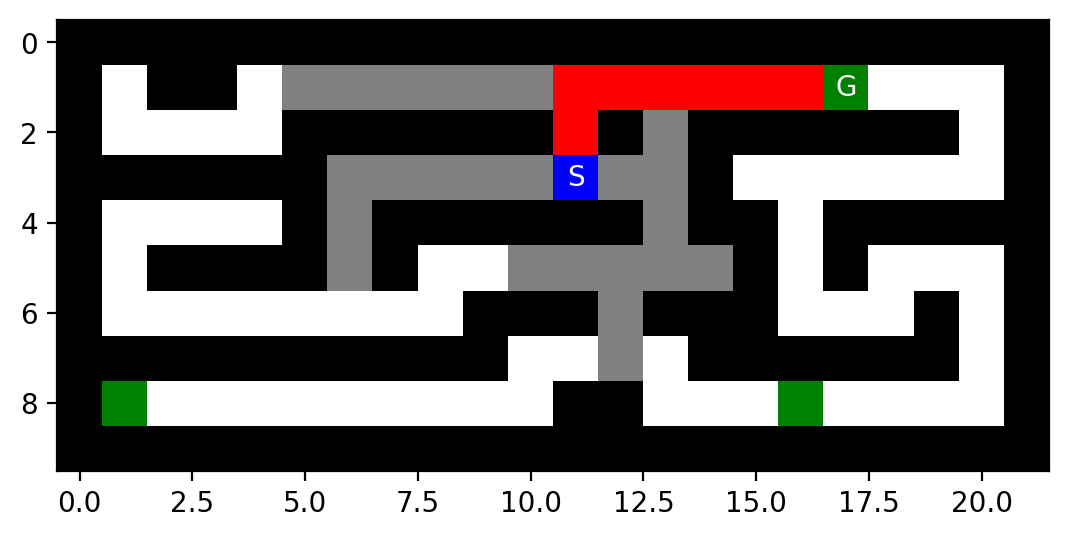

In [21]:
# Your code/answer goes here
with open("new_maze.txt", "r") as f:
    new_maze = f.read()

new_maze = mh.parse_maze(new_maze)
def find_pos_multiple_goals(maze, what="G"):
    positions = []
    for r in range(maze.shape[0]):
        for c in range(maze.shape[1]):
            if maze[r, c] == what:
                positions.append((r, c))
    return positions
end_positions = find_pos_multiple_goals(new_maze, what="G")
bdsout =DFS_multi(new_maze, end_positions)
#DFS
print(f"Path form start to goal using DFS:")
mh.show_maze(bdsout)

bdsout =BFS_multi(new_maze, end_positions)
#BFS
print(f"Path form start to goal using BFS:")
mh.show_maze(bdsout)

bdsout = new_IDS(new_maze, end_positions)
#IDS
print(f"Path form start to goal using IDS:")
mh.show_maze(bdsout)





## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [22]:
def find_intersections(maze, start, goal):
    intersections = set()
    rows, cols = len(maze), len(maze[0])

    def neighbors(pos):
        x, y = pos
        moves = [(0,1),(0,-1),(1,0),(-1,0)]
        return [(x+dx,y+dy) for dx,dy in moves
                if 0 <= x+dx < rows and 0 <= y+dy < cols and maze[x+dx][y+dy] != '#']

    for i in range(rows):
        for j in range(cols):
            if maze[i][j] != '#':
                pos = (i,j)
                neighs = neighbors(pos)
                if pos == start or pos == goal or len(neighs) != 2:
                    intersections.add(pos)
    return intersections


def build_graph_from_intersections(maze, intersections):
    graph = {p: [] for p in intersections}
    rows, cols = len(maze), len(maze[0])

    def neighbors(pos):
        x, y = pos
        moves = [(0,1),(0,-1),(1,0),(-1,0)]
        return [(x+dx,y+dy) for dx,dy in moves
                if 0 <= x+dx < rows and 0 <= y+dy < cols and maze[x+dx][y+dy] != '#']

    for inter in intersections:
        for nxt in neighbors(inter):
            cost = 1
            path_pos = nxt
            prev = inter
            while path_pos not in intersections:
                neighs = neighbors(path_pos)
                # đi tiếp (loại bỏ prev)
                if len(neighs) == 0: break
                next_pos = neighs[0] if neighs[0] != prev else neighs[1]
                prev, path_pos = path_pos, next_pos
                cost += 1
            if path_pos in intersections:
                graph[inter].append((path_pos, cost))
    return graph


### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

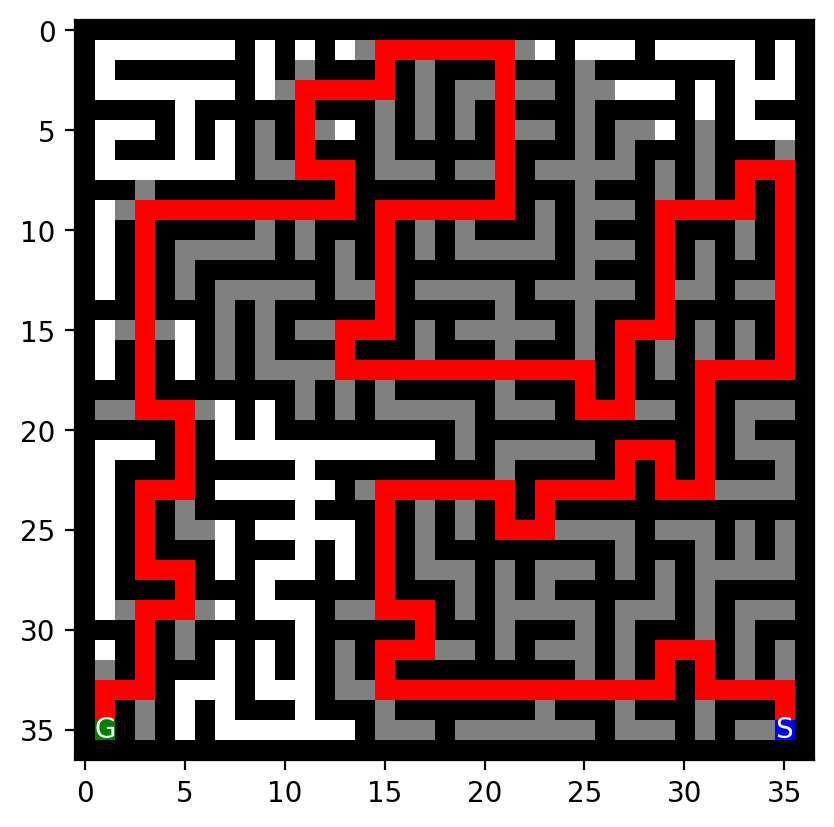

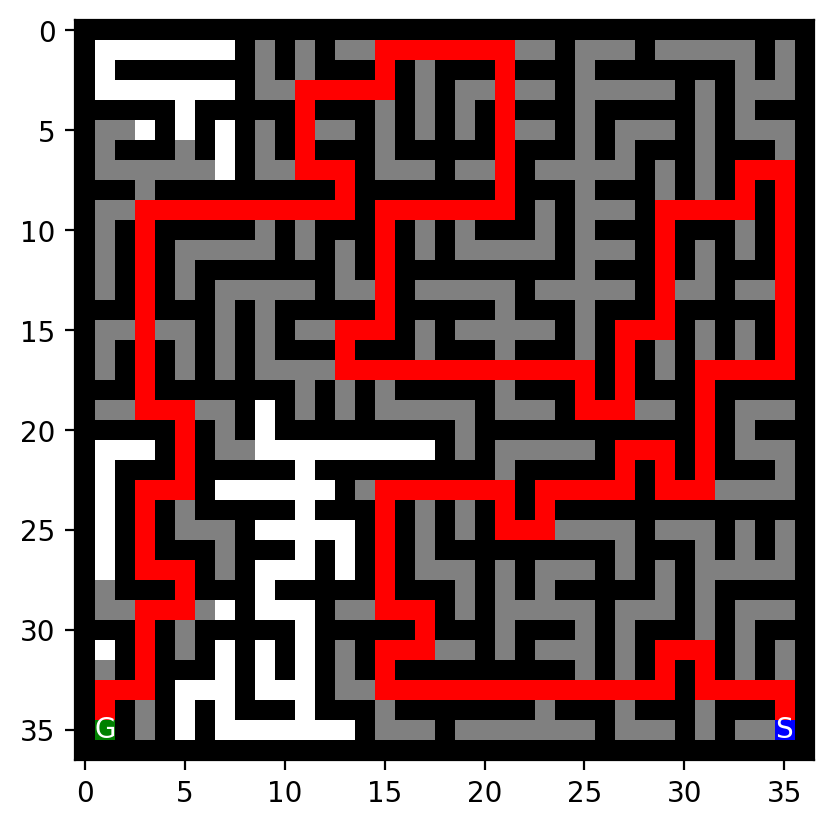

In [23]:
# Your code/answer goes here
def A_star_search_add_weight(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Weight = 10
        # Sort the frontier based on the f(n) = g(n) + 10*h(n)
        frontier.sort(key=lambda node: node.cost + 10*(abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1])))
        node = frontier.pop(0)  # Pop the node with the lowest f(n) value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
with open("large_maze.txt", "r") as f:
    maze_str_medium = f.read()

medium_maze = mh.parse_maze(maze_str_medium)
new = A_star_search_add_weight(medium_maze)
mh.show_maze(new)
new = A_star_search(medium_maze)
mh.show_maze(new)


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

## Unknown Maze

Khi agent **không biết bản đồ trước**:

**PEAS description**  
- **Performance (P):** đến goal nhanh, ít bước, ít va chạm.  
- **Environment (E):** maze chưa biết trước, deterministic, có tường và ô trống.  
- **Actuators (A):** di chuyển 4 hướng (trái, phải, lên, xuống).  
- **Sensors (S):** cảm nhận tường xung quanh; nếu có GPS → biết vị trí và khoảng cách Manhattan tới goal.  

**Rational agent**  
- Không có bản đồ: phải dùng **online search** (exploration + planning).  
  - Ví dụ: Online DFS, LRTA* (Learning Real-Time A*).  
  - Agent duy trì bản đồ nội bộ, cập nhật khi di chuyển.  
  - Nếu gặp ngõ cụt thì quay lại (backtracking).  
- Có GPS: có thể tính heuristic (Manhattan distance), dùng **online A*** hoặc **LRTA*** để định hướng tốt hơn.  

**Kết luận:**  
- Maze unknown → agent phải vừa tìm vừa khám phá.  
- Có GPS → dùng heuristic để dẫn đường hiệu quả hơn nhưng vẫn cần khám phá khi gặp tường.


In [25]:
def LRTA_star_agent(state, goal, maze, H, result, cost):
    """
    Pseudo-code LRTA* (Russell & Norvig)
    - state: vị trí hiện tại
    - goal: vị trí đích
    - H: bảng heuristic (dictionary), khởi tạo = Manhattan
    - result: lưu kết quả hành động
    - cost: chi phí giữa 2 state
    """
    if state == goal:
        return "STOP"

    # cập nhật heuristic tại state hiện tại
    for action in actions(state, maze):
        s_prime = result.get((state, action), None)
        if s_prime:
            H[state] = min(H[state], cost(state, action, s_prime) + H[s_prime])

    # chọn action tốt nhất (minimize estimated cost)
    best_action = argmin(actions(state, maze),
                         key=lambda a: cost(state, a, result.get((state, a), state))
                                       + H[result.get((state, a), state)])
    return best_action
